In [1]:
import numpy as np
import essentia.standard as estd
import essentia as ess
import scipy
import pandas as pd
import csv
import re
import os
import IPython.display as ipd
import tempfile
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sns.set()

In [2]:
# Set base directory where the dataset is located
dataset_root = "../Dataset/tabla_solo_1.0"

# Define the rest of paths
filelist_path = os.path.join(dataset_root, 'filelist.txt')
audio_files_path = os.path.join(dataset_root, "wav")
annotation_files_path = os.path.join(dataset_root, "onsMap")

# Filename for features to be saved and loaded from
features_filename = "extracted_features.csv"

# Path for classifier outputs 
results_path = "./results"

# List of all possible bols
BOL_NAMES = ['DA', 'KI', 'GE', 'TA', 'NA', 'DIN', 'KDA', 'TIT', 'DHA', 
        'DHE', 'DHET', 'DHI', 'DHIN', 'RE', 'TE', 'TII', 'TIN', 'TRA']

# Collect list of datafiles
filenames = [line.rstrip('\n') for line in open(filelist_path)]

In [3]:
def flatten_pool(pool):
    '''
    For each enumerable feature in a pool, create separate field for each value
    '''
    for feature in pool.descriptorNames():
        if hasattr(pool[feature], '__iter__'):
            values_list = pool[feature]
            pool.remove(feature)
            for i, elem in enumerate(values_list):
                pool.set("{}.{}".format(feature,i), elem)
    return pool

def extract_mfccs(audio_frame):
    '''
    Extracts mean mfcss from given audio frame. Mimicks behavior of HTK.
    
    Arguments:
        - audio_frame:[float] - audio frame
    Returns:
        - result:dictionary – a dictionary of calculated mean mfccs
    '''
    # HTK-like parameters for MFCC
    mfcc_extractor = estd.MFCC(
        type = 'magnitude',
        warpingFormula = 'htkMel',
        weighting = 'linear',
        highFrequencyBound = 8000,
        numberBands = 26,
        numberCoefficients = 13,
        normalize = 'unit_max',
        dctType = 3,
        logType = 'log',
        liftering = 22
    )
    
    # HTK-like Parameters for FrameGenerator
    frame_generator = estd.FrameGenerator(
        audio_frame,
        frameSize = 1102,
        hopSize = 441,
        startFromZero = True,
        validFrameThresholdRatio = 1
    )
    
    # HTK-like parameters for windowing
    window = estd.Windowing(
        type = 'hamming',
        size = 1102,
        zeroPadding = 946,
        normalized = False
    )
    
    spectrum = estd.Spectrum()
    
    features = ess.Pool()
    mfccs = []
    for frame in frame_generator:
        spec = spectrum(window(frame))
        _, mfcc_coeffs = mfcc_extractor(spec)
        mfccs.append(mfcc_coeffs)

    
    mfccs = np.array(mfccs).T
    mfccs_delta = np.diff(mfccs)
    mfccs_delta_delta = np.diff(mfccs_delta)
    mfccs_dict = {
        'htk_mfccs': mfccs,
        'htk_mfccs_delta': mfccs_delta,
        'htk_mfccs_delta_delta': mfccs_delta_delta
    }
    for feature, mfccs in mfccs_dict.items():
        for coeff_id, values in enumerate(mfccs):
            for value in values:
                features.add("%s.%d" % (feature, coeff_id), value)

    # Pool aggregation
    aggregated = estd.PoolAggregator(defaultStats=['mean','stdev'])(features)
    return aggregated
    
    
def extract_features(audio_frame):
    '''
    Extracts multiple features using Essentia's Extractor
    
    Arguments:
        - audio_frame:[float] - audio frame
    Returns:
        - results:pool – Essentia's pool datastructure with aggregated features
    '''
    extractor = estd.Extractor(highLevel=False, 
                    midLevel=False,
                    relativeIoi=False,
                    rhythm=False,
                    tuning=False,
                    lowLevelFrameSize=1024,
                    lowLevelHopSize = 512,
                   )
    
    pool = extractor(audio_frame)
    
    pool_aggregator = estd.PoolAggregator(defaultStats=['mean','stdev'])
    return flatten_pool(pool_aggregator(pool))


def analyse_file(fname, slice_length=100, skip_length=0):
    '''
    Analyses the file at give filepath
    
    Arguments:
        - fname:path - path to the filename
        - slice_length:float - length of a bol slice in ms
        - skip_start:float - length of bol beginning to skip in ms
    Returns:
        - result:[pool] - list of Essentia's pools with extracted features for each bol
    '''
    fs = 44100
    
    # Calculate parameters
    frame_size = int(slice_length*fs/1000)
    skip_samples = int(skip_length*fs/1000)
    
    # Load audio
    audio_file = os.path.join(audio_files_path, fname+'.wav')
    audio = estd.MonoLoader(filename=audio_file)()

    # Load annotation
    annotation_file = os.path.join(annotation_files_path, fname+'.csv')
    df = pd.read_csv(annotation_file, header=None)
    
    # Extract features
    bols = []
    bols_number = {}
    for item in df.itertuples(index=False):
        timestamp = item[0]
        
        # 'Class'
        bol_name = item[1].strip()
        bol_id = BOL_NAMES.index(bol_name)
        if bol_id not in bols_number:
            bols_number[bol_id] = 0
        bols_number[bol_id] += 1

        start_frame = int(np.round(timestamp*fs)) + skip_samples
        end_frame = start_frame + frame_size
        audio_slice = audio[start_frame : end_frame]
        
        extractor_pool = extract_features(audio_slice)
        mfcc_pool = extract_mfccs(audio_slice)
        extractor_pool.merge(mfcc_pool)
        extractor_pool.set('bol_id', bol_id)
        
        bols.append(extractor_pool)
        
    return bols
        

In [4]:
# Extract all features
slice_length = 100
skip_length = 0
pools = []
for fname in filenames:
    pools += analyse_file(fname, slice_length, skip_length)

In [5]:
# Save features to CSV file
attributes = pools[0].descriptorNames()
problematic_frames = 0
with open(features_filename, "w") as file:
    file.write(",".join(attributes) + "\n")
    attributes.remove('bol_id')
    for pool in pools:
        try:
            bol_name = BOL_NAMES[int(pool['bol_id'])]
            vals = [bol_name]
            vals += ([pool[attribute] for attribute in attributes])
            file.write(",".join([str(item) for item in vals])+"\n")
        except KeyError:
            problematic_frames += 1
            
print("Saved features to %s. There was a problem with %d out of %d frames." % (features_filename, problematic_frames, len(pools)))

Saved features to extracted_features.csv. There was a problem with 6 out of 8245 frames.


In [6]:
# Convert 'NA' syllable back to 'NA' (Pandas converts NA values to NaN)
df = pd.read_csv(features_filename, converters={'bol_id': lambda x: BOL_NAMES.index(str(x))})

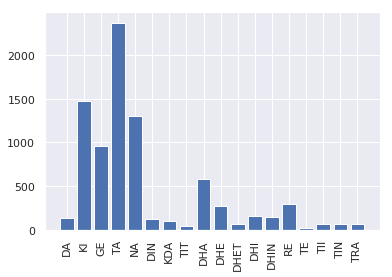

In [7]:
# For statistical purposes
bols_number = {}
for name in range(len(BOL_NAMES)):
    bols_number[name] = len(df[df['bol_id'] == name])
    
x_bols = np.arange(len(bols_number))
y_bols = bols_number.values()

plt.bar(x_bols, y_bols)
plt.xticks(x_bols, BOL_NAMES, rotation='vertical')
plt.show()

In [13]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=11):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 11.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='center', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [14]:
def report(clf, X, y, clf_name, log_to_file=False):
    sys.stdout = sys.__stdout__
    if log_to_file:
        # Create results directory if doesn't exist
        try:  
            os.mkdir(results_path)
        except:
            # Directory already exists
            pass
        # Redirect stdout
        textfile = open(os.path.join(results_path, clf_name+'.txt'), 'w')
        sys.stdout = textfile
    
    print("Results for %s classifier\n\n" % clf_name)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random.randint(0,10000))
    k_fold = KFold(10)
    print("----------------------------------------------------")
    print("10-fold validation results\n")
    for k, (train, test) in enumerate(k_fold.split(X_train, y_train)):
        clf.fit(X_train[train], y_train[train])
        acc = clf.score(X_train[test], y_train[test])
        print("Fold no %d: %f accuracy." % (k+1, acc))
        
    y_predict = clf.predict(X_test)
    unique_classes = np.unique(list(y_test) +  list(y_predict))
    class_names = [BOL_NAMES[class_id] for class_id in sorted(unique_classes)]
    clf_report = classification_report(y_test, y_predict, target_names=class_names)
    
    print("----------------------------------------------------")
    print("\nClassification report\n")
    print(clf_report)
    
    # Calculate and save confusion matrix figure
    cm = confusion_matrix(y_test, y_predict)
    print("----------------------------------------------------")
    print(cm)
    cmfig = print_confusion_matrix(cm, class_names)

    if log_to_file:
        cmfig.savefig(os.path.join(results_path, clf_name+'--cm.pdf'))
        sys.stdout = sys.__stdout__
        textfile.close()

In [15]:
# FEATURE SELECTION: Uncomment expected behavior

all_columns = list(df.columns)
all_columns.remove('bol_id')

# All the columns
# fset_id = 'all'
# selected_columns = all_columns

# Only automatically computed mfccs
# fset_id = 'lowLevel.mfcc'
# selected_columns = [column for column in all_columns if 'lowLevel.mfcc' in column]

# Only htk MFCCs + derivatives
# fset_id = 'htk_mfcc'
# selected_columns = [column for column in all_columns if 'htk_mfcc' in column]

# All features apart of automatically computed mfccs
fset_id = 'not-lowLevel.mfcc'
selected_columns = [column for column in all_columns if 'lowLevel.mfcc' not in column]

# Get features matrix
X = df[selected_columns].values
# Extract classes
y = df['bol_id'].values

/home/ninad/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


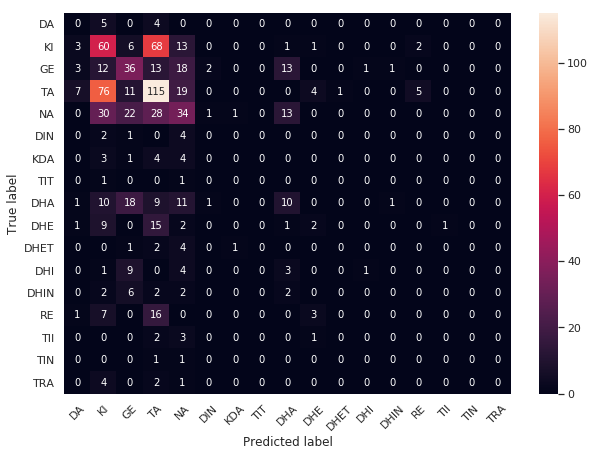

In [16]:
# K-Nearest Neighbour
knn_clf = KNeighborsClassifier()
report(knn_clf, X, y, 'knn'+fset_id, log_to_file=True)

/home/ninad/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


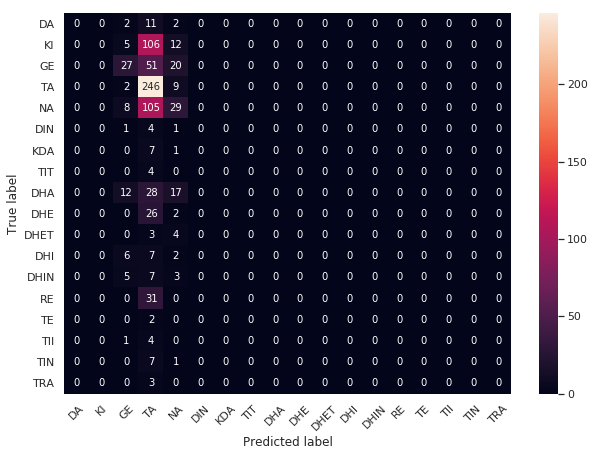

In [17]:
# Support Vector Machines
svm_clf = svm.SVC(kernel='poly', C=1, degree=3, gamma='scale')
report(svm_clf, X, y, 'svn--'+fset_id, log_to_file=True)

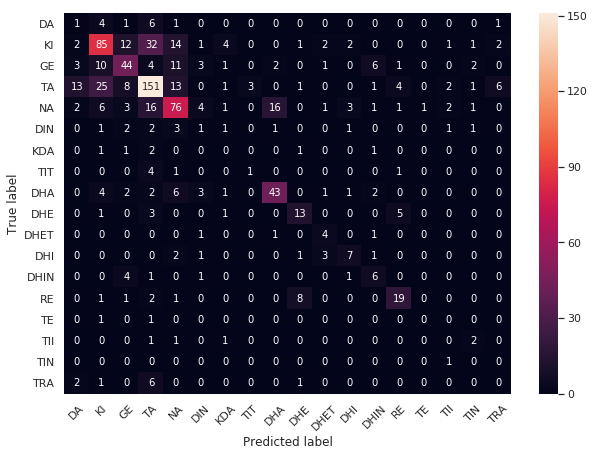

In [18]:
# Descision tree
tree = DecisionTreeClassifier()
report(tree, X, y, 'tree--'+fset_id, log_to_file=True)